Step 1 - Data collection

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip
!ls


Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fake-and-real-news-dataset.zip
replace Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Fake.csv                
replace True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: True.csv                
fake-and-real-news-dataset.zip	fake_news_data	sample_data
Fake.csv			kaggle.json	True.csv


Step 2 - Data loading and Preparation

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")


In [ ]:
print(fake_df.shape)
print(true_df.shape)

fake_df.head()

(23481, 4)
(21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake_df['label'] = 0   # Fake
true_df['label'] = 1   # Real

In [ ]:
df = pd.concat([fake_df, true_df], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,title,text,subject,date,label
0,"Tillerson urges Iraq, Kurds to resolve conflic...",BAGHDAD (Reuters) - U.S. Secretary of State Re...,worldnews,"October 23, 2017",1
1,BERKELEY COLLEGE THUGS Form Human Chain To Sto...,"Students at the University of California, Berk...",politics,"Oct 25, 2016",0
2,TRUMP RUFFLES FEATHERS With New And Bold Presi...,Who knew that members of a presidential admini...,politics,"Dec 23, 2017",0
3,Republican Asks Trump To Roll Back Protection...,The party of rape is at it again.Republicans a...,News,"December 30, 2016",0
4,LIBERAL SNOWFLAKE Ambushes Sean Spicer in Appl...,Read more: Daily Mail,left-news,"Mar 13, 2017",0


In [ ]:
df = df[['title', 'text', 'label']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   text    44898 non-null  object
 2   label   44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


Step 3 - Text preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                         # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)        # remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()    # remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
df[['text', 'clean_text']].head()

,text,clean_text
0,BAGHDAD (Reuters) - U.S. Secretary of State Re...,baghdad reuters us secretary state rex tillers...
1,"Students at the University of California, Berk...",students university california berkeley held d...
2,Who knew that members of a presidential admini...,knew members presidential administration coins...
3,The party of rape is at it again.Republicans a...,party rape againrepublicans drunk power impend...
4,Read more: Daily Mail,read daily mail


Step 4 - Tokenization & Text Representation

In [ ]:
X = df['clean_text']
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(35918, 5000)
(8980, 5000)


Step 5 - Machine Learning Model Training

In [ ]:
#STEP-5.1: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9928730512249443
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4730
           1       0.99      0.99      0.99      4250

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
#STEP-5.2: Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.9502227171492205
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4730
           1       0.95      0.95      0.95      4250

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [ ]:
#STEP-5.3: Support Vector Machine (SVM)
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9966592427616926
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4730
           1       1.00      1.00      1.00      4250

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
results = {
    "Logistic Regression": accuracy_score(y_test, y_pred_lr),
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "SVM": accuracy_score(y_test, y_pred_svm)
}

results


{'Logistic Regression': 0.9928730512249443,
 'Naive Bayes': 0.9502227171492205,
 'SVM': 0.9966592427616926}

STEP-6: Confusion Matrix & Visualization (Single Block)

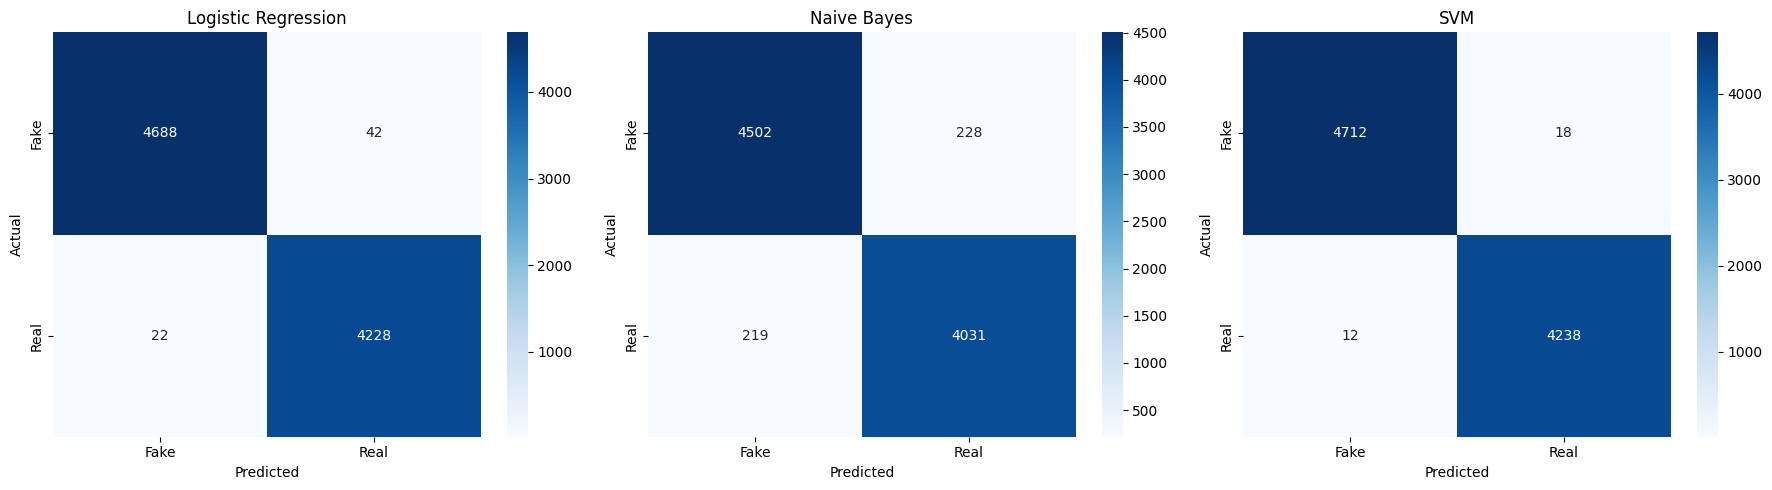

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models_preds = {
    "Logistic Regression": y_pred_lr,
    "Naive Bayes": y_pred_nb,
    "SVM": y_pred_svm
}

plt.figure(figsize=(18,5))

for i, (name, preds) in enumerate(models_preds.items(), 1):
    plt.subplot(1,3,i)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake','Real'],
                yticklabels=['Fake','Real'])
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


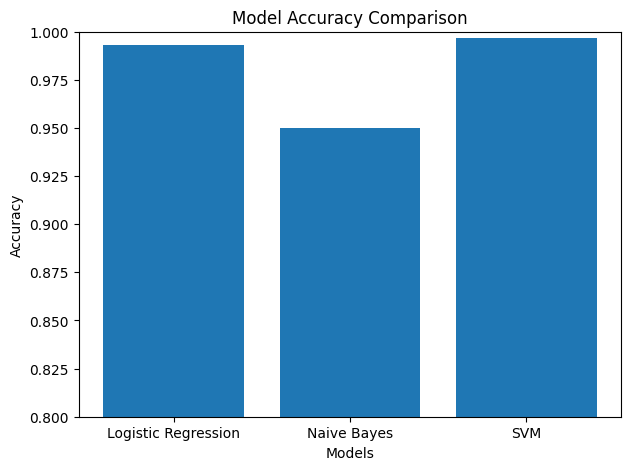

In [ ]:
import matplotlib.pyplot as plt

models = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(7,5))
plt.bar(models, accuracies)
plt.ylim(0.8,1.0)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

df = pd.DataFrame({
    "Logistic Regression": [report_lr['weighted avg']['precision'], report_lr['weighted avg']['recall'], report_lr['weighted avg']['f1-score']],
    "Naive Bayes": [report_nb['weighted avg']['precision'], report_nb['weighted avg']['recall'], report_nb['weighted avg']['f1-score']],
    "SVM": [report_svm['weighted avg']['precision'], report_svm['weighted avg']['recall'], report_svm['weighted avg']['f1-score']]
}, index=["Precision", "Recall", "F1-score"])

df


,Logistic Regression,Naive Bayes,SVM
Precision,0.992885,0.950230,0.996660
Recall,0.992873,0.950223,0.996659
F1-score,0.992874,0.950225,0.996659
